In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

torch.set_default_dtype(torch.float32)

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, shuffle=True, batch_size=128)

testset = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, shuffle=False)

In [3]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [4]:
class MLP(nn.Module):
    def __init__(self, num_features: int, num_hidden: int, dropout = 0.0) -> None:
        super().__init__()
        self.fc1 = nn.Linear(num_features, num_hidden)
        self.fc2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_hidden, num_features),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)

        return x

class TokenMixture(nn.Module):
    def __init__(self, num_features, num_patches, num_hidden, dropout) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(num_features)
        self.mlp = MLP(num_patches, num_hidden, dropout)

    def forward(self, x):
        _x = x
        x = self.layer_norm(x)
        x = x.transpose(1, 2)
        x = torch.transpose(self.mlp(x), 1, 2)

        return x + _x

class ChannelMixture(nn.Module):
    def __init__(self, num_features, num_hidden, dropout) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(num_features)
        self.mlp = MLP(num_features, num_hidden, dropout)

    def forward(self, x):
        _x = x
        x = self.layer_norm(x)
        x = self.mlp(x)

        return x + _x

class Mixer(nn.Module):
    def __init__(self, num_features, num_hidden, dropout) -> None:
        super().__init__()
        self.token_mix = TokenMixture(num_features, num_hidden, dropout)
        self.channel_mix = ChannelMixture(num_features, num_hidden, dropout)

    def forward(self, x):
        return self.channel_mix(self.token_mix(x))


class MLPMixer(nn.Module):
    def __init__(
        self,
        image_size = 256, 
        patch_size = 16, 
        in_channels = 3,
        num_features = 128,
        num_hidden = 256,
        num_layers = 8,
        dropout = 0.5,
        num_classes = 10
    ):
        super().__init__()
        assert(image_size % patch_size == 0)
        num_patches = int((image_size / patch_size) ** 2)
        self.projection = nn.Conv2d(
            in_channels, num_features, kernel_size=patch_size, stride=patch_size
        )

        self.mixers = nn.Sequential(*[
            x for _ in range(num_layers) for x in [TokenMixture(num_features, num_patches, num_hidden, dropout), ChannelMixture(num_features, num_hidden, dropout)]
        ])
        self.fc = nn.Linear(num_features, num_classes)
        # assert(len(self.mixers) == num_layers)

    def forward(self, x):
        tokens = self.projection(x)
        batch_size, num_features, _, _ = tokens.shape
        tokens = tokens.permute(0, 2, 3, 1)

        # flatten the output of the conv net
        tokens = tokens.view(batch_size, -1, num_features)
        embedding = self.mixers(tokens)
        embedding = embedding.mean(dim=1)

        y = self.fc(embedding)
        return y


In [7]:
model = MLPMixer(image_size=28, patch_size=4, num_classes=10, in_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
device

'cuda'

In [8]:
epochs = 20
total_data = len(trainloader)
for epoch in range(epochs):
    for i, (data, label) in tqdm(enumerate(trainloader)):
        data = data.to(device)
        label = label.to(device)
        pred = model(data)
        loss = loss_fn(pred, label)
        
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch: {epoch} Loss {i} / {total_data}: {torch.linalg.norm(loss)}")

        optimizer.zero_grad()

0it [00:00, ?it/s]

Epoch: 0 Loss 0 / 469: 2.3676319122314453
Epoch: 0 Loss 100 / 469: 1.0122566223144531
Epoch: 0 Loss 200 / 469: 0.8659898638725281
Epoch: 0 Loss 300 / 469: 0.3946665823459625
Epoch: 0 Loss 400 / 469: 0.39888113737106323


0it [00:00, ?it/s]

Epoch: 1 Loss 0 / 469: 0.4230394661426544
Epoch: 1 Loss 100 / 469: 0.18746066093444824
Epoch: 1 Loss 200 / 469: 0.21999290585517883
Epoch: 1 Loss 300 / 469: 0.25569063425064087
Epoch: 1 Loss 400 / 469: 0.23728308081626892


0it [00:00, ?it/s]

Epoch: 2 Loss 0 / 469: 0.2688256502151489
Epoch: 2 Loss 100 / 469: 0.3521481156349182
Epoch: 2 Loss 200 / 469: 0.32683250308036804
Epoch: 2 Loss 300 / 469: 0.21533553302288055
Epoch: 2 Loss 400 / 469: 0.3510553538799286


0it [00:00, ?it/s]

Epoch: 3 Loss 0 / 469: 0.09617148339748383
Epoch: 3 Loss 100 / 469: 0.140562042593956
Epoch: 3 Loss 200 / 469: 0.14119425415992737
Epoch: 3 Loss 300 / 469: 0.09528326243162155
Epoch: 3 Loss 400 / 469: 0.24621503055095673


0it [00:00, ?it/s]

Epoch: 4 Loss 0 / 469: 0.16243715584278107
Epoch: 4 Loss 100 / 469: 0.17957492172718048
Epoch: 4 Loss 200 / 469: 0.19601573050022125
Epoch: 4 Loss 300 / 469: 0.10344281792640686
Epoch: 4 Loss 400 / 469: 0.14167027175426483


0it [00:00, ?it/s]

Epoch: 5 Loss 0 / 469: 0.27921566367149353
Epoch: 5 Loss 100 / 469: 0.15721620619297028
Epoch: 5 Loss 200 / 469: 0.23234492540359497
Epoch: 5 Loss 300 / 469: 0.12420821189880371
Epoch: 5 Loss 400 / 469: 0.09185126423835754


0it [00:00, ?it/s]

Epoch: 6 Loss 0 / 469: 0.05939870700240135
Epoch: 6 Loss 100 / 469: 0.22254516184329987
Epoch: 6 Loss 200 / 469: 0.3087906837463379
Epoch: 6 Loss 300 / 469: 0.28637322783470154
Epoch: 6 Loss 400 / 469: 0.07719412446022034


0it [00:00, ?it/s]

Epoch: 7 Loss 0 / 469: 0.11011390388011932
Epoch: 7 Loss 100 / 469: 0.13700464367866516
Epoch: 7 Loss 200 / 469: 0.11109574884176254
Epoch: 7 Loss 300 / 469: 0.12361544370651245
Epoch: 7 Loss 400 / 469: 0.1359281837940216


0it [00:00, ?it/s]

Epoch: 8 Loss 0 / 469: 0.08842885494232178
Epoch: 8 Loss 100 / 469: 0.15966080129146576
Epoch: 8 Loss 200 / 469: 0.0997103750705719
Epoch: 8 Loss 300 / 469: 0.1521540880203247
Epoch: 8 Loss 400 / 469: 0.31857338547706604


0it [00:00, ?it/s]

Epoch: 9 Loss 0 / 469: 0.13161629438400269
Epoch: 9 Loss 100 / 469: 0.1223016157746315
Epoch: 9 Loss 200 / 469: 0.20950961112976074
Epoch: 9 Loss 300 / 469: 0.18044447898864746
Epoch: 9 Loss 400 / 469: 0.12484578788280487


0it [00:00, ?it/s]

Epoch: 10 Loss 0 / 469: 0.17384834587574005
Epoch: 10 Loss 100 / 469: 0.08746014535427094
Epoch: 10 Loss 200 / 469: 0.08271759748458862
Epoch: 10 Loss 300 / 469: 0.08503048121929169
Epoch: 10 Loss 400 / 469: 0.10939870774745941


0it [00:00, ?it/s]

Epoch: 11 Loss 0 / 469: 0.1256280541419983
Epoch: 11 Loss 100 / 469: 0.12809939682483673
Epoch: 11 Loss 200 / 469: 0.12592396140098572
Epoch: 11 Loss 300 / 469: 0.07501387596130371
Epoch: 11 Loss 400 / 469: 0.04756048321723938


0it [00:00, ?it/s]

Epoch: 12 Loss 0 / 469: 0.13392487168312073
Epoch: 12 Loss 100 / 469: 0.041729867458343506
Epoch: 12 Loss 200 / 469: 0.09988128393888474
Epoch: 12 Loss 300 / 469: 0.06596039980649948
Epoch: 12 Loss 400 / 469: 0.08781301975250244


0it [00:00, ?it/s]

Epoch: 13 Loss 0 / 469: 0.1848321408033371
Epoch: 13 Loss 100 / 469: 0.20504090189933777
Epoch: 13 Loss 200 / 469: 0.16331855952739716
Epoch: 13 Loss 300 / 469: 0.2210175096988678
Epoch: 13 Loss 400 / 469: 0.15632325410842896


0it [00:00, ?it/s]

Epoch: 14 Loss 0 / 469: 0.1640724539756775
Epoch: 14 Loss 100 / 469: 0.11476641148328781
Epoch: 14 Loss 200 / 469: 0.06861657649278641
Epoch: 14 Loss 300 / 469: 0.10355272889137268
Epoch: 14 Loss 400 / 469: 0.049159809947013855


0it [00:00, ?it/s]

Epoch: 15 Loss 0 / 469: 0.08120589703321457
Epoch: 15 Loss 100 / 469: 0.2323259711265564
Epoch: 15 Loss 200 / 469: 0.15178683400154114
Epoch: 15 Loss 300 / 469: 0.09412641078233719
Epoch: 15 Loss 400 / 469: 0.06859388202428818


0it [00:00, ?it/s]

Epoch: 16 Loss 0 / 469: 0.0763472393155098
Epoch: 16 Loss 100 / 469: 0.13405956327915192
Epoch: 16 Loss 200 / 469: 0.06474924087524414
Epoch: 16 Loss 300 / 469: 0.11995603889226913
Epoch: 16 Loss 400 / 469: 0.13212965428829193


0it [00:00, ?it/s]

Epoch: 17 Loss 0 / 469: 0.08886708319187164
Epoch: 17 Loss 100 / 469: 0.1528165340423584
Epoch: 17 Loss 200 / 469: 0.21454428136348724
Epoch: 17 Loss 300 / 469: 0.1422031819820404
Epoch: 17 Loss 400 / 469: 0.08529128134250641


0it [00:00, ?it/s]

Epoch: 18 Loss 0 / 469: 0.05289027467370033
Epoch: 18 Loss 100 / 469: 0.10599994659423828
Epoch: 18 Loss 200 / 469: 0.10973843932151794
Epoch: 18 Loss 300 / 469: 0.174700066447258
Epoch: 18 Loss 400 / 469: 0.03484340012073517


0it [00:00, ?it/s]

Epoch: 19 Loss 0 / 469: 0.1339006870985031
Epoch: 19 Loss 100 / 469: 0.019359441474080086
Epoch: 19 Loss 200 / 469: 0.17967434227466583
Epoch: 19 Loss 300 / 469: 0.07092496007680893
Epoch: 19 Loss 400 / 469: 0.09224380552768707


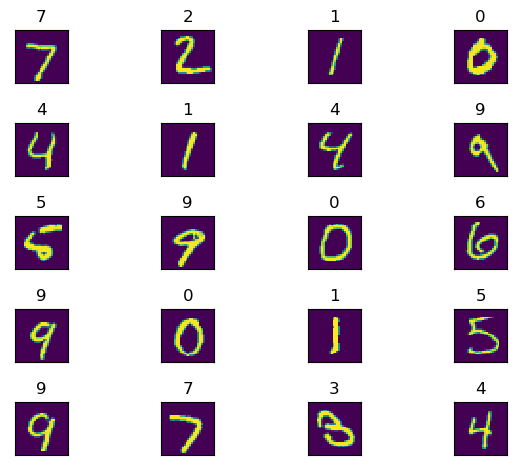

In [31]:
row_size = 5
col_size = 4
for i, (data, label) in enumerate(testloader):
    plt.subplot(row_size, col_size, i + 1)
    plt.imshow(data.detach().numpy()[0].reshape((28, 28)), cmap='viridis', interpolation='none')
    plt.title(f"{model(data.to(device)).argmax()}")
    plt.xticks([])
    plt.yticks([])
    if i >= row_size * col_size - 1:
        break
        
plt.tight_layout()
plt.show()